In [87]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
import time
import nltk
from collections import Counter
from nltk.corpus import stopwords  
from nltk.tokenize import word_tokenize  
from nltk.tokenize import RegexpTokenizer
from langid.langid import LanguageIdentifier, model
import re


In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/boudokh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [81]:
reviews_df = pd.read_csv("groover_dataset_challenge.csv")
reviews_df = reviews_df.set_index('id').drop("Unnamed: 0",axis=1)

In [82]:
reviews_df.dtypes

band_id            int64
influencer_id      int64
feedback          object
score            float64
dtype: object

In [83]:
reviews_df.isna().sum()

band_id          0
influencer_id    0
feedback         0
score            0
dtype: int64

In [88]:
reviews_df.feedback = reviews_df.feedback.apply(lambda x: re.sub(r'\n+',' ', x))
reviews_df.feedback

id
920636    Bonjour Diogo Ramos, Merci pour le partage. Ac...
920637    Un message touchant, développé sur une onde mu...
920639    Bonjour ! Merci beaucoup pour l'envoi ! On n'e...
920640    Bonjour. Merci pour cette fraîcheur et cet hym...
920641    Salut Diogo, alors c'est un peu éloigné de ce ...
                                ...                        
936179    Hey guys, thanks for sharing, great sound, alt...
936241    Hello MD One, thank you for your track Bombe A...
936266    Hi! Thanks for sharing your track! I really li...
936274    This is an exceptionally produced electro-pop ...
936392    Yo c'est pas mal ce que tu fais ! Les prod c'e...
Name: feedback, Length: 10000, dtype: object

on remarque que cet texte contient des feedbacks en français et en anglais! ceci est important si on veut effectuer de la lemmatisation plus tard
je vais alors essayer de deviner la langue de chaque grace à cet outil:
https://github.com/saffsd/langid.py

In [89]:
identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
reviews_df['language'] = reviews_df.feedback.apply(identifier.classify)
reviews_df[['language','lang_confidence']] = pd.DataFrame(reviews_df['language'].tolist(), index=k.index)
reviews_df

,band_id,influencer_id,feedback,score,language,lang_confidence
id,,,,,,
920636,24665,1642,"Bonjour Diogo Ramos, Merci pour le partage. Ac...",0.00,fr,1.0
920637,24665,118,"Un message touchant, développé sur une onde mu...",0.00,fr,1.0
920639,24665,226,Bonjour ! Merci beaucoup pour l'envoi ! On n'e...,0.00,fr,1.0
920640,24665,1603,Bonjour. Merci pour cette fraîcheur et cet hym...,1.00,fr,1.0
920641,24665,111,"Salut Diogo, alors c'est un peu éloigné de ce ...",1.00,fr,1.0
...,...,...,...,...,...,...
936179,30049,3499,"Hey guys, thanks for sharing, great sound, alt...",1.00,en,1.0
936241,33795,2570,"Hello MD One, thank you for your track Bombe A...",0.00,en,1.0
936266,18877,2598,Hi! Thanks for sharing your track! I really li...,1.00,en,1.0


In [90]:
reviews_df.isna().sum()

band_id            0
influencer_id      0
feedback           0
score              0
language           0
lang_confidence    0
dtype: int64

In [111]:
len(reviews_df.band_id.unique()), len(reviews_df.influencer_id.unique())


(940, 9517, 872)

In [91]:
reviews_df[reviews_df.lang_confidence < 0.98]

,band_id,influencer_id,feedback,score,language,lang_confidence
id,,,,,,
925439,12412,2101,"Olá Santos, tudo bem com você? Gostei muito...",0.25,pt,0.944387
926426,9241,2101,"Olá QLAPs, tudo bem com você? Gostei muito do ...",0.25,fr,0.906224
928037,8063,2101,"Olá Franck Dansaert, tudo bem com você? Gostei...",0.25,br,0.900079
932044,33835,2501,"HELLO PRO STREAM, HOW ARE U? HOPE THAT U ARE G...",0.25,en,0.963665


In [92]:
reviews_df[~reviews_df.language.isin(['fr','en'])]

,band_id,influencer_id,feedback,score,language,lang_confidence
id,,,,,,
920676,29872,737,"Hola socio es un placer saludarte, he escuchad...",0.25,es,1.0
920754,32440,2765,"Ciao, grazie per averci inviato il vostro pezz...",0.00,it,1.0
920840,23712,2000,Ciao sono Marco Racchella MRP75 direttore arti...,0.50,it,1.0
920974,33092,2000,Ciao sono Marco Racchella MRP75 direttore arti...,0.50,it,1.0
920980,30813,3092,"Sono passati i 7 giorni? Scherzi a parte, hai ...",0.25,it,1.0
...,...,...,...,...,...,...
934936,27682,3334,"Ciao, il pezzo è davvero forte! Ci piace molto...",1.00,it,1.0
935599,32752,3008,"Ciao Pierfrancesco, innanzitutto complimenti p...",1.00,it,1.0
935870,29867,2043,Que voz incrível. Estamos fascinados! Com tod...,1.00,pt,1.0


<AxesSubplot:xlabel='language', ylabel='Count'>

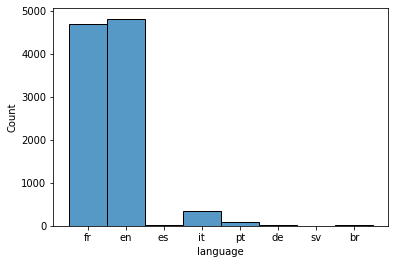

In [93]:
sns.histplot(data=reviews_df, x="language")

In [94]:
reviews_df = reviews_df[reviews_df.language.isin(['fr','en'])]
reviews_df = reviews_df[reviews_df.lang_confidence > 0.98]
reviews_df

,band_id,influencer_id,feedback,score,language,lang_confidence
id,,,,,,
920636,24665,1642,"Bonjour Diogo Ramos, Merci pour le partage. Ac...",0.00,fr,1.0
920637,24665,118,"Un message touchant, développé sur une onde mu...",0.00,fr,1.0
920639,24665,226,Bonjour ! Merci beaucoup pour l'envoi ! On n'e...,0.00,fr,1.0
920640,24665,1603,Bonjour. Merci pour cette fraîcheur et cet hym...,1.00,fr,1.0
920641,24665,111,"Salut Diogo, alors c'est un peu éloigné de ce ...",1.00,fr,1.0
...,...,...,...,...,...,...
936179,30049,3499,"Hey guys, thanks for sharing, great sound, alt...",1.00,en,1.0
936241,33795,2570,"Hello MD One, thank you for your track Bombe A...",0.00,en,1.0
936266,18877,2598,Hi! Thanks for sharing your track! I really li...,1.00,en,1.0


In [95]:
unique, counts = np.unique(reviews_df.score, return_counts=True)
unique, counts

(array([0.  , 0.25, 0.5 , 1.  ]), array([6203,  991,  155, 2168]))

<AxesSubplot:>

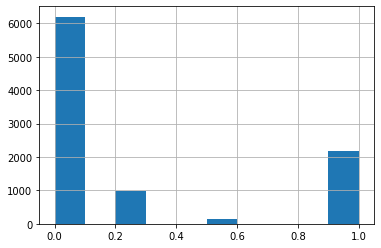

In [96]:
reviews_df.score.hist()

In [97]:
reviews_df['word_count'] = reviews_df.feedback.apply(lambda x: len(x.split()))
reviews_df['char_count'] = reviews_df.feedback.apply(lambda x: len(x))
reviews_df[['char_count','word_count','score']].describe()

,char_count,word_count,score
count,9517.000000,9517.000000,9517.000000
mean,286.355049,49.460019,0.261979
std,256.265778,43.021933,0.412029
min,71.000000,16.000000,0.000000
25%,156.000000,27.000000,0.000000
50%,218.000000,38.000000,0.000000
75%,334.000000,58.000000,0.250000
max,4603.000000,774.000000,1.000000


<AxesSubplot:xlabel='char_count', ylabel='Count'>

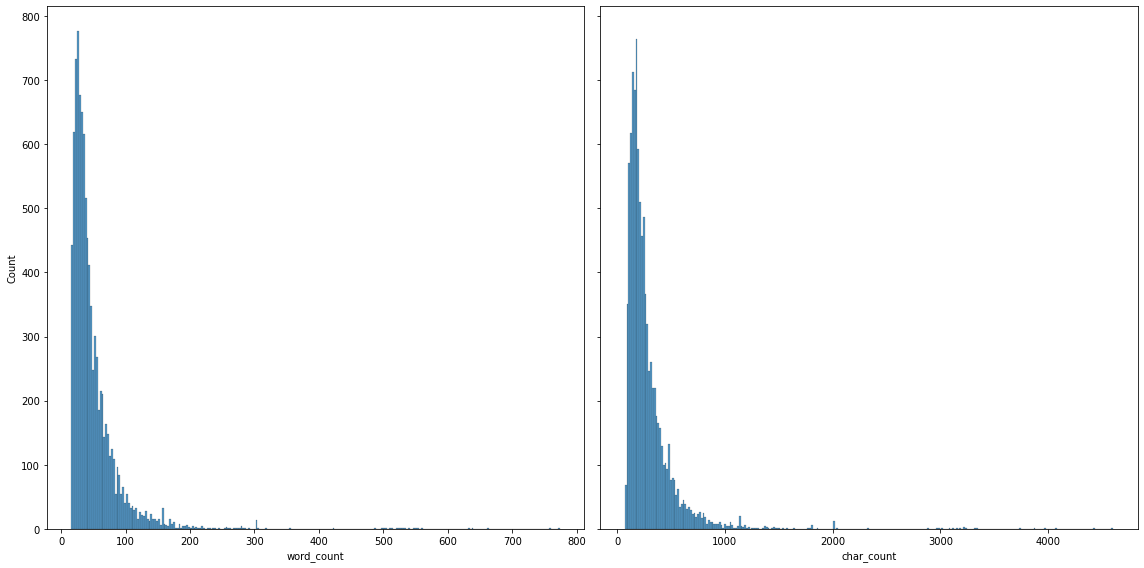

In [98]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(16, 8))
sns.histplot(data=reviews_df, x="word_count",  ax=axs[0])
sns.histplot(data=reviews_df, x="char_count",  ax=axs[1])


In [99]:
full_corpus = word_tokenize(" ".join(reviews_df.feedback.tolist()))
word_occurences = Counter(full_corpus)
word_occurences.most_common(20)

[('.', 23811),
 (',', 23518),
 ('the', 10371),
 ('!', 8832),
 ('de', 7804),
 ('a', 6639),
 ('and', 5972),
 ('I', 5679),
 ('to', 5364),
 ('for', 5175),
 ('et', 4784),
 ('pour', 4755),
 ('le', 4457),
 ('à', 4329),
 ('la', 4229),
 ('you', 4059),
 ('it', 3870),
 ('of', 3579),
 ('pas', 3502),
 ('is', 3443)]

on observe donc que le haut de la liste est rempli de stop words et de ponctuation qu'on devrait chercher à éliminer tout comme les majucules.

In [100]:
full_corpus = [w.lower() for w in full_corpus if w.isalpha()]
word_occurences = Counter(full_corpus)
word_occurences.most_common(20)

[('the', 11736),
 ('de', 7903),
 ('a', 7307),
 ('i', 6418),
 ('and', 6036),
 ('to', 5415),
 ('le', 5407),
 ('for', 5269),
 ('pour', 5022),
 ('et', 4890),
 ('la', 4749),
 ('à', 4512),
 ('it', 4512),
 ('you', 4324),
 ('of', 3594),
 ('pas', 3581),
 ('on', 3527),
 ('nous', 3512),
 ('is', 3464),
 ('un', 3446)]

In [101]:
word_occurences_df = pd.DataFrame.from_dict(word_occurences, columns=['occurences'], orient='index').sort_values(by=['occurences'], ascending=False)

stop_words_en = set(stopwords.words('english'))
stop_words_fr = set(stopwords.words('french'))
stop_words={'en':stop_words_en, 'fr':stop_words_fr}

stop_words_full = stop_words_en.union(stop_words_fr)
word_occurences_df['is_stop_word'] = word_occurences_df.index.to_series().apply(lambda x: True if x in stop_words_full else False)
word_occurences_df

,occurences,is_stop_word
the,11736,True
de,7903,True
a,7307,True
i,6418,True
and,6036,True
...,...,...
bonjur,1,False
ambiançant,1,False
cristallin,1,False
cossett,1,False


In [102]:
import spacy

nlp_fr = spacy.load('fr_core_news_sm')
nlp_en = spacy.load('en_core_web_sm')


In [103]:
def lemmatize(text, language):
    if language is 'fr':
        doc = nlp_fr(str(text))
    else:
        doc = nlp_en(str(text))
    return [w.lemma_ for w in doc if (not w.is_stop and not w.is_punct and not w.like_num)]

In [105]:
reviews_df['lemma'] = reviews_df.apply(lambda x: lemmatize(x.feedback, x.language), axis=1)
reviews_df

In [164]:
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

In [126]:
vectorizer = TfidfVectorizer(max_features=10000,
                            tokenizer=lambda x: x,
                            lowercase=False)

In [160]:
reviews_df = shuffle(reviews_df) 

x = reviews_df.drop(["score"], axis=1)
y = (reviews_df["score"]*4).astype('int')

X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.25, random_state=42)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape


((7137, 8), (7137,), (2380, 8), (2380,))

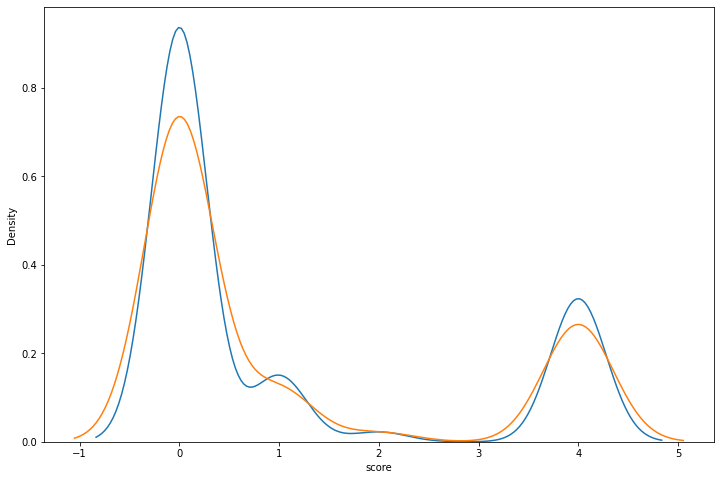

In [161]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
sns.distplot(y_train, hist=False)
sns.distplot(y_valid, hist=False)
plt.show()


In [162]:
X_train_tfidf = vectorizer.fit_transform(X_train['lemma'])
X_valid_tfidf = vectorizer.transform(X_valid['lemma'])

In [169]:
rf = RandomForestClassifier(n_estimators=1000,
                            max_depth = 20)

rf.fit(X_train_tfidf, y_train.values)


RandomForestClassifier(max_depth=20, n_estimators=1000)

In [171]:
y_rf_pred = pd.DataFrame(rf.predict(X_valid_tfidf))

print("Matrice de confusion de la forêt aléatoire : ")
print(confusion_matrix(y_valid, y_rf_pred))
print("Score de précision de la forêt aléatoire : "+str(round(precision_score(y_valid, y_rf_pred, average='weighted')*100,2)))
print("Score de rappel de la forêt aléatoire : "+str(round(recall_score(y_valid, y_rf_pred, average='weighted')*100,2)))
print("Score F1 de la régression forêt aléatoire : "+str(round(f1_score(y_valid, y_rf_pred, average='weighted')*100,2)))

Matrice de confusion de la forêt aléatoire : 
[[1532    0    0    2]
 [ 228   19    0    0]
 [  30    0   14    0]
 [ 369    0    0  186]]
Score de précision de la forêt aléatoire : 81.03
Score de rappel de la forêt aléatoire : 73.57
Score F1 de la régression forêt aléatoire : 67.53
